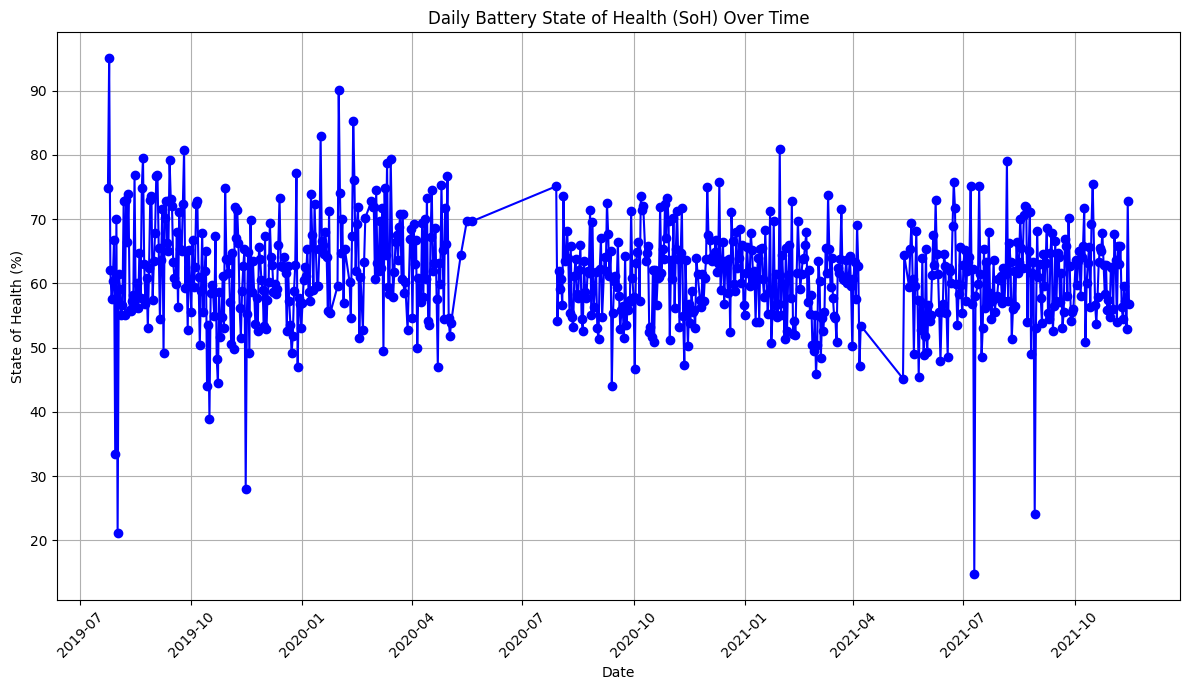

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

# Load your dataset
# Replace 'your_dataset.csv' with the path to your actual dataset file
df = pd.read_csv('Dataset/#10.csv')

# Assuming record_time format is YYYYMMDDHHMMSS
df['record_time'] = pd.to_datetime(df['record_time'], format='%Y%m%d%H%M%S')

# Set the original capacity of the battery when new
original_capacity_Ah = 140  # Adjust this value based on your battery's original capacity

# Group by date and calculate average available capacity for each day
df['date'] = df['record_time'].dt.date
daily_capacity = df.groupby('date')['available_capacity (Ah)'].mean().reset_index()

# Calculate daily SoH based on the average available capacity
daily_capacity['SoH_capacity'] = (daily_capacity['available_capacity (Ah)'] / original_capacity_Ah) * 100

# Plot daily SoH over time
plt.figure(figsize=(12, 7))
plt.plot(daily_capacity['date'], daily_capacity['SoH_capacity'], marker='o', linestyle='-', color='blue')
plt.title('Daily Battery State of Health (SoH) Over Time')
plt.xlabel('Date')
plt.ylabel('State of Health (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


In [2]:
# Assuming daily_capacity is your prepared DataFrame
# Let's create a simple lag feature as an example predictor
daily_capacity['SoH_capacity_lag1'] = daily_capacity['SoH_capacity'].shift(1)

# Drop the first row since it will have NaN values due to the lag
daily_capacity = daily_capacity.dropna()

# Define features and target
X = daily_capacity[['SoH_capacity_lag1']]  # Add more features as needed
y = daily_capacity['SoH_capacity']




In [3]:
# Assuming df is your original DataFrame and it includes an 'available_energy (kw)' column
df['date'] = df['record_time'].dt.date  # Ensure this line is present if not already done
daily_energy = df.groupby('date')['available_energy (kw)'].mean().reset_index()  # Calculate daily average available energy

# Merge daily available energy values with daily SoH calculations
daily_data = pd.merge(daily_capacity, daily_energy, on='date')

# Now daily_data contains both SoH_capacity and average daily available energy


In [6]:
# Define the feature and target variable
X = daily_data[['available_energy (kw)']]  # daily average available energy as the feature
y = daily_data['SoH_capacity']  # daily SoH as the target


In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search
param_grid = {
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'learning_rate': [0.03, 0.1, 0.2, 0.3],
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [100, 120, 140],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize GridSearchCV with the XGBRegressor and the parameter grid
grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits
Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.6}
Best score found:  -0.6920108112686899


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Predict on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Assuming y_test and y_pred are defined
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")

RMSE: 0.4589013995427997
MAE: 0.1639866228518574
R-squared: 0.996572757517418


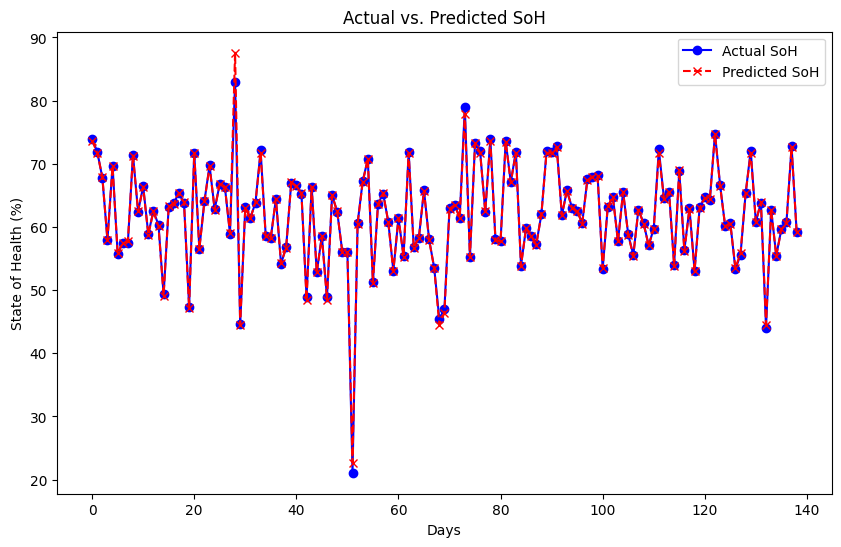

In [11]:
import matplotlib.pyplot as plt

# Ensure you have y_test and y_pred from the previous steps

# Convert y_test to a numpy array if it's not already (for indexing purposes)
y_test_array = y_test.to_numpy()

# Plot actual vs. predicted SoH
plt.figure(figsize=(10, 6))
plt.plot(y_test_array, label='Actual SoH', color='blue', marker='o')
plt.plot(y_pred, label='Predicted SoH', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted SoH')
plt.xlabel('Days')
plt.ylabel('State of Health (%)')
plt.legend()
plt.show()


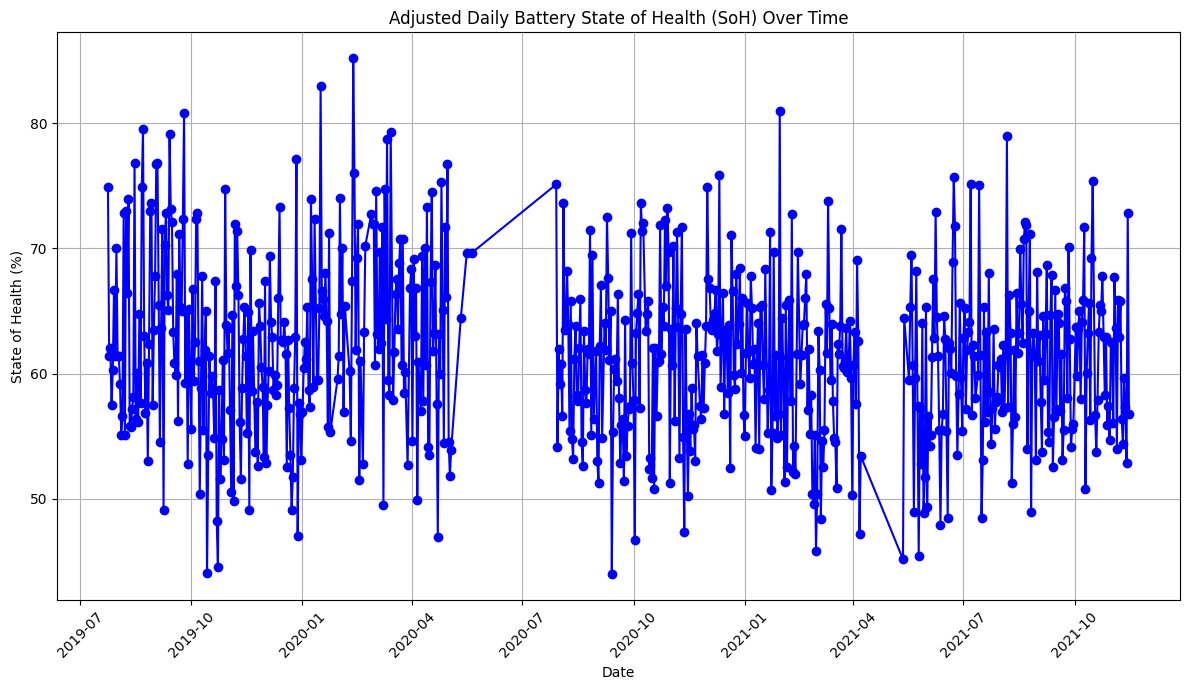

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

# Load your dataset
df = pd.read_csv('Dataset/#10.csv')

# Assuming record_time format is YYYYMMDDHHMMSS
df['record_time'] = pd.to_datetime(df['record_time'], format='%Y%m%d%H%M%S')

# Set the original capacity of the battery when new
original_capacity_Ah = 140  # Adjust this value based on your battery's original capacity

# Group by date and calculate average available capacity for each day
df['date'] = df['record_time'].dt.date
daily_capacity = df.groupby('date')['available_capacity (Ah)'].mean().reset_index()

# Calculate daily SoH based on the average available capacity
daily_capacity['SoH_capacity'] = (daily_capacity['available_capacity (Ah)'] / original_capacity_Ah) * 100

# Calculate the mean of the whole SoH_capacity data
mean_SoH_capacity = daily_capacity['SoH_capacity'].mean()

# Identify outliers and replace their SoH_capacity values with the mean of the whole data
daily_capacity.loc[(daily_capacity['SoH_capacity'] > 90) | (daily_capacity['SoH_capacity'] < 40), 'SoH_capacity'] = mean_SoH_capacity

# Plot daily SoH over time after adjustment
plt.figure(figsize=(12, 7))
plt.plot(daily_capacity['date'], daily_capacity['SoH_capacity'], marker='o', linestyle='-', color='blue')
plt.title('Adjusted Daily Battery State of Health (SoH) Over Time')
plt.xlabel('Date')
plt.ylabel('State of Health (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


In [ ]:
# Assuming daily_capacity is your prepared DataFrame
# Let's create a simple lag feature as an example predictor
daily_capacity['SoH_capacity_lag1'] = daily_capacity['SoH_capacity'].shift(1)

# Drop the first row since it will have NaN values due to the lag
daily_capacity = daily_capacity.dropna()

# Define features and target
X = daily_capacity[['SoH_capacity_lag1']]  # Add more features as needed
y = daily_capacity['SoH_capacity']


In [ ]:
# Assuming df is your original DataFrame and it includes an 'available_energy (kw)' column
df['date'] = df['record_time'].dt.date  # Ensure this line is present if not already done
daily_energy = df.groupby('date')['available_energy (kw)'].mean().reset_index()  # Calculate daily average available energy

# Merge daily available energy values with daily SoH calculations
daily_data = pd.merge(daily_capacity, daily_energy, on='date')

# Now daily_data contains both SoH_capacity and average daily available energy

In [ ]:
# Define the feature and target variable
X = daily_data[['available_energy (kw)']]  # daily average available energy as the feature
y = daily_data['SoH_capacity']  # daily SoH as the target


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import time

# Define the hyperparameter grid to search
param_grid = {
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'learning_rate': [0.03, 0.1, 0.2, 0.3],
    'max_depth': [2, 3, 4, 5],
    'n_estimators': [100, 120, 140],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize GridSearchCV with the XGBRegressor and the parameter grid
grid_search = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
start_time = time.time()
# Fit the model
grid_search.fit(X_train, y_train)
end_time = time.time()
# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)
print("Model triaining time: {:f} saniye".format(end_time - start_time))

In [ ]:
from sklearn.metrics import mean_squared_error

# Predict on the test set
y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Test MSE: ", mse)

In [ ]:
import matplotlib.pyplot as plt

# Ensure you have y_test and y_pred from the previous steps

# Convert y_test to a numpy array if it's not already (for indexing purposes)
y_test_array = y_test.to_numpy()

# Plot actual vs. predicted SoH
plt.figure(figsize=(10, 6))
plt.plot(y_test_array, label='Actual SoH', color='blue', marker='o')
plt.plot(y_pred, label='Predicted SoH', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted SoH')
plt.xlabel('Days')
plt.ylabel('State of Health (%)')
plt.legend()
plt.show()